## Import libraries

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from helpers.data_utils import get_noise, get_one_hot_labels, combine_vectors, ImageDataset, show_tensor_images
from helpers.evaluate import Interpolate
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load original dataset 

In [2]:
data_file = "datasets/all_baf_valid_50deg_filtered3.csv"
classes = "classes.txt"
dataset = ImageDataset(data_file=data_file,
                       fpath_col_name="file.path",
                       lbl_col_name="gene",
                       class_vals=classes)

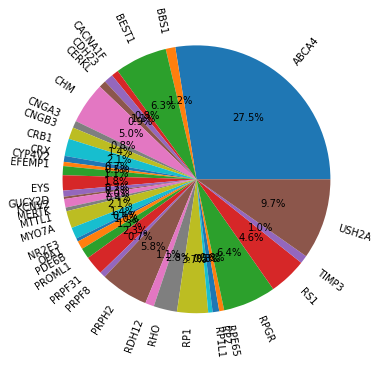

In [3]:
classes, class_rep = np.unique(dataset.img_labels, return_counts=True)
class_rep_df = pd.DataFrame({'Class':classes, '%':class_rep})
plt.figure(figsize=(6, 12))
plt.pie(class_rep, labels=classes, autopct="%.1f%%", rotatelabels=True)
plt.show()

In [4]:
class_rep_df = class_rep_df.sort_values(by=["%"], ascending=False)
np.sum(class_rep_df["%"])

15642

# Load model and weights

In [5]:
# configs
model_name = "cmsggan"
n_classes = dataset.n_classes
z_dim = 512
resolution = 256
depth = int(np.log2(resolution) - 1)
weights_dir = "checkpoints/data:all_baf_valid_50deg_filtered3.csv_classes:classes.txt_trans:256-1-1_mod:cmsggan-512-256_tr:1000-RAHinge-48-1-0.003-0.003-0.0-0.99/"
weights_file = "model_ema_state_100.pth"

In [6]:
# load architecture
if model_name == "cmsggan":
    from models.msggan import conditional_msggan
    gan_model = conditional_msggan.MSG_GAN(latent_size=z_dim,
                                           mode="grayscale",
                                           depth=depth,
                                           n_classes=n_classes).gen_shadow.to(device)

elif model_name == "cmsgganv2":
    from models.msggan import conditional_msgganv2
    gan_model = conditional_msgganv2.Generator(latent_size=z_dim,
                                               mode="grayscale",
                                               depth=depth,
                                               n_classes=n_classes).to(device)

In [7]:
# load weights
gan_model = torch.nn.DataParallel(gan_model)
gan_model.load_state_dict(torch.load(weights_dir+weights_file))

<All keys matched successfully>

## Generate some random images

In [13]:
noise = get_noise(10, 512, device)
labels = torch.randint(low=0, high=dataset.n_classes, size=(10,)).to(device)

if model_name == "cmsggan":
    one_hot_labels = get_one_hot_labels(labels, dataset.n_classes)
    noise_and_labels = combine_vectors(noise, one_hot_labels)

generated_images = gan_model(noise_and_labels)
image_adjustor = conditional_msggan.Generator.adjust_dynamic_range
generated_images = [image_adjustor(generated_image)for generated_image in generated_images]

In [22]:
[dataset.idx2class[l.item()] for l in labels]

['CRX',
 'MTTL1',
 'USH2A',
 'CACNA1F',
 'EFEMP1',
 'PRPH2',
 'PROML1',
 'GUCY2D',
 'GUCY2D',
 'CNGB3']

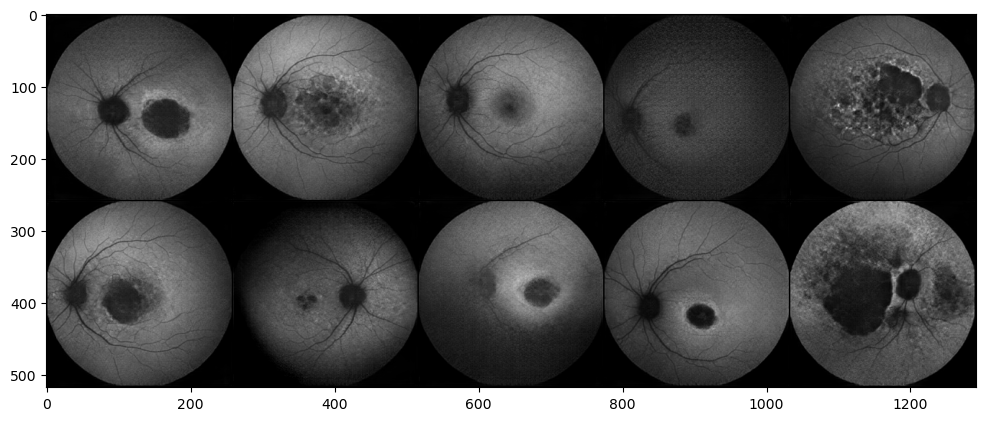

In [14]:
# visualize images
plt.figure(figsize=(12, 12))
_ = show_tensor_images(generated_images[-1], normalize=False, show_image=True)

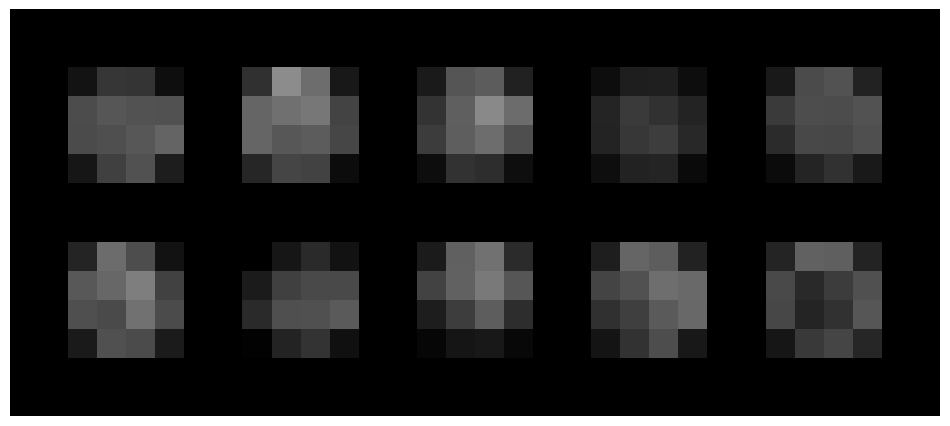

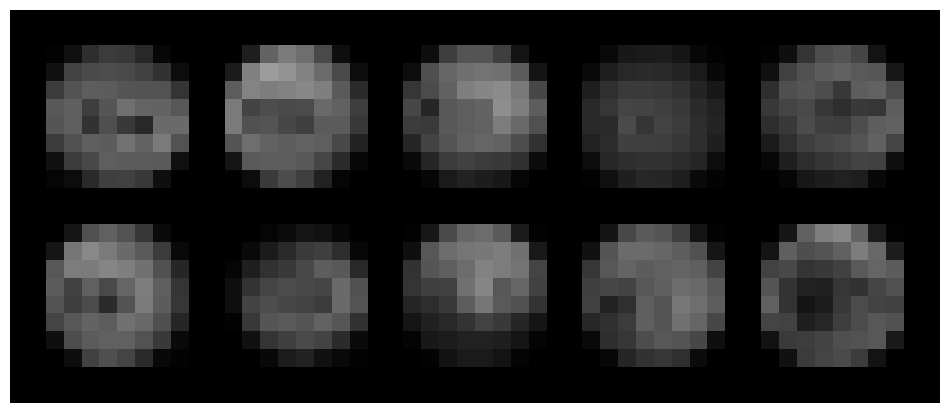

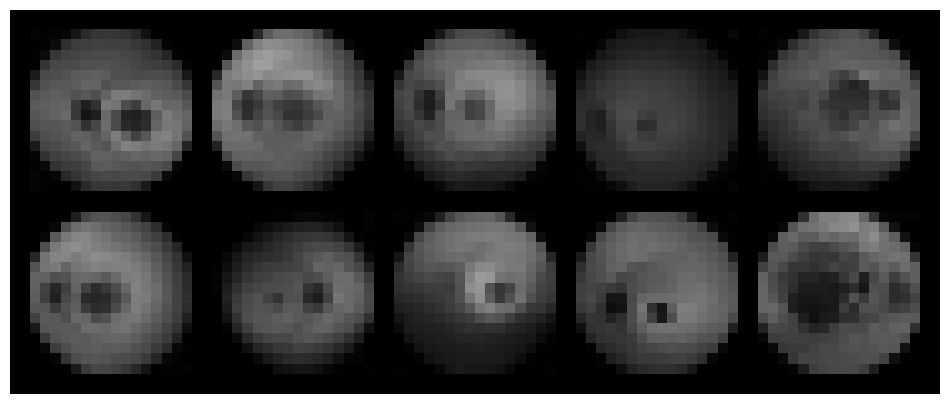

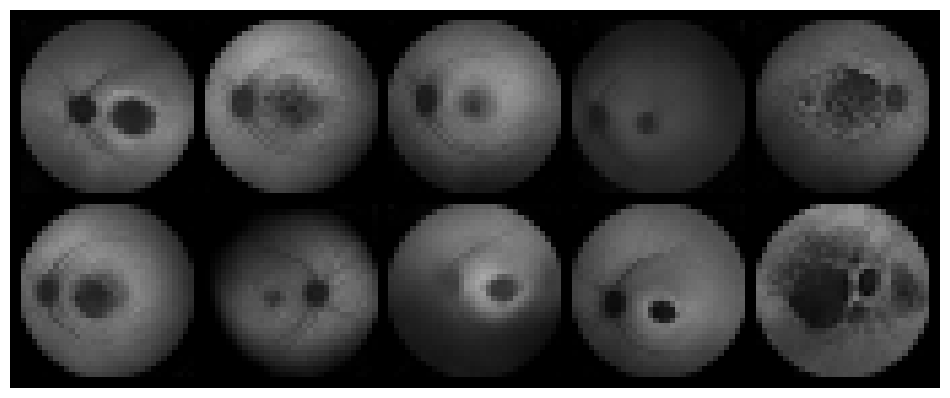

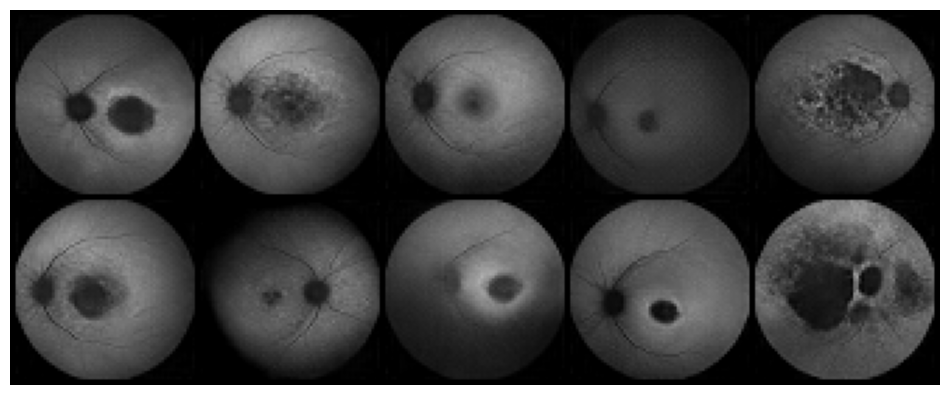

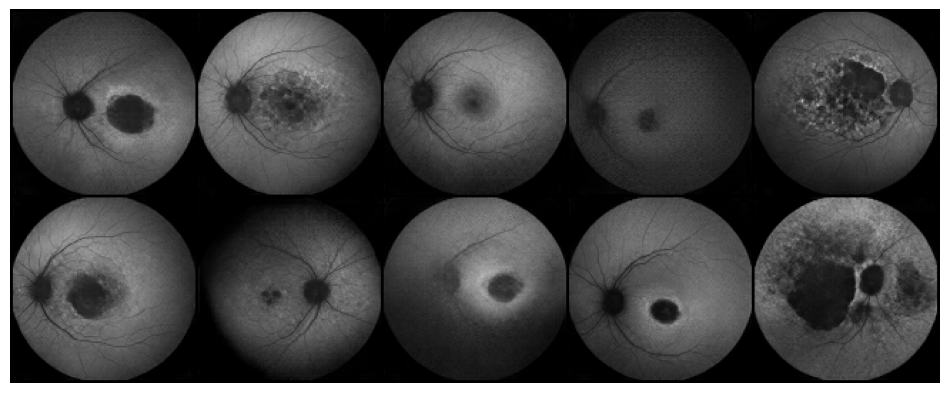

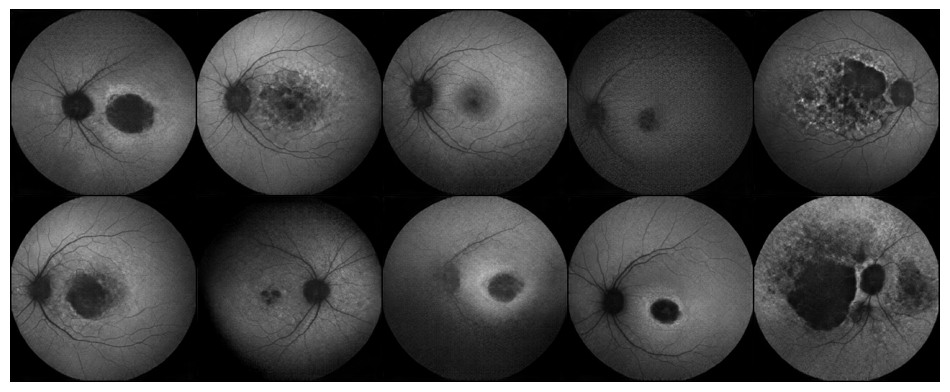

In [15]:
save_folder = "results/gif_imgs/"
os.makedirs(save_folder, exist_ok=True)
for i in range(len(generated_images)):
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    _ = show_tensor_images(generated_images[i], normalize=False, show_image=True, save_path=save_folder+"res_{}".format(i))

## Exploring the latent space

### Interpolate between classes

In [8]:
interpolator = Interpolate(gan_model, interp="classes", n_classes=dataset.n_classes, n_interpolation=9, device=device)

In [23]:
noise = get_noise(1, 512, device)
class1 = 'BEST1'
class2 = 'PRPH2'
class1_idx = torch.tensor([dataset.class2idx[class1]])
class2_idx = torch.tensor([dataset.class2idx[class2]])
interpolations = interpolator(noise, class1_idx, class2_idx)
image_adjustor = conditional_msggan.Generator.adjust_dynamic_range
interpolations[-1] = image_adjustor(interpolations[-1])

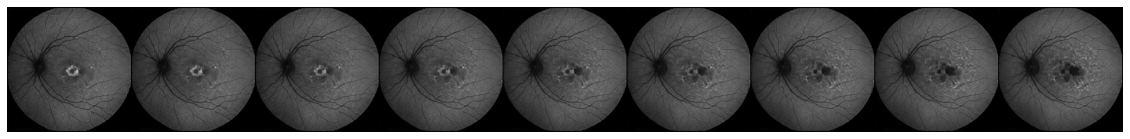

In [24]:
plt.figure(figsize=(20, 6))
_ = plt.axis('off')
_ = show_tensor_images(interpolations[-1], n_rows=9, normalize=False, show_image=True)

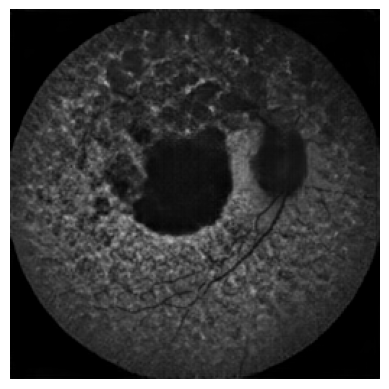

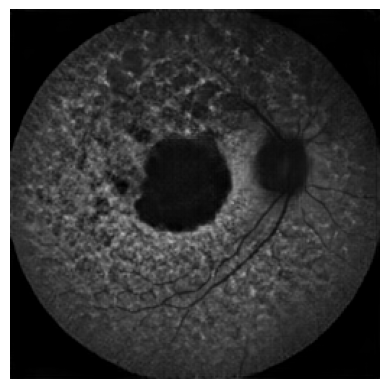

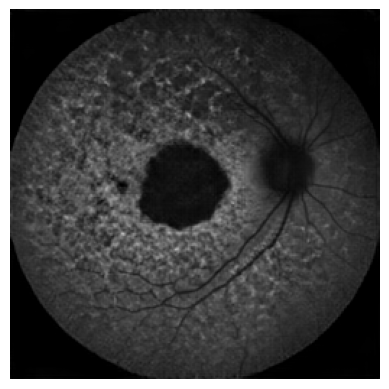

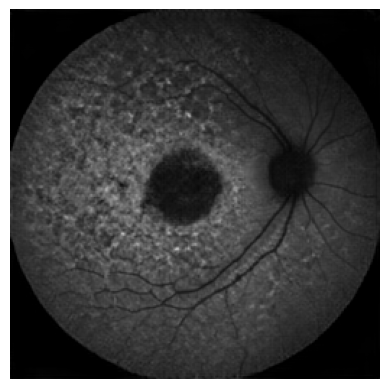

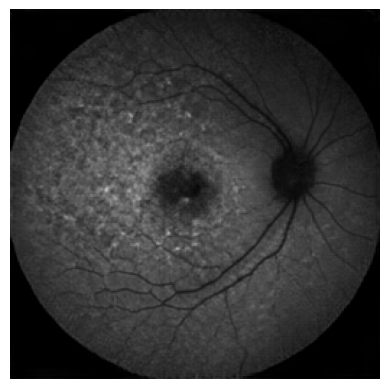

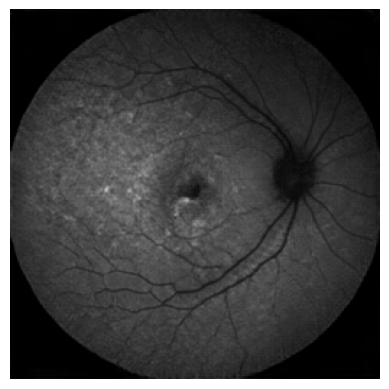

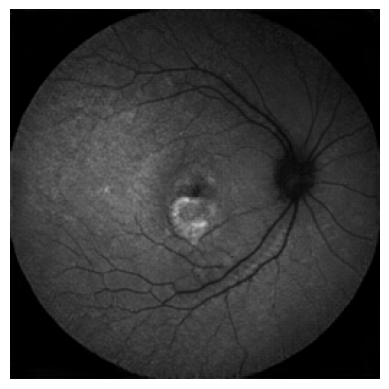

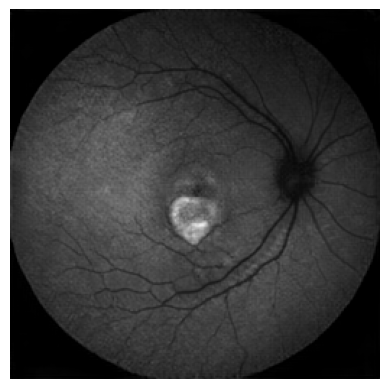

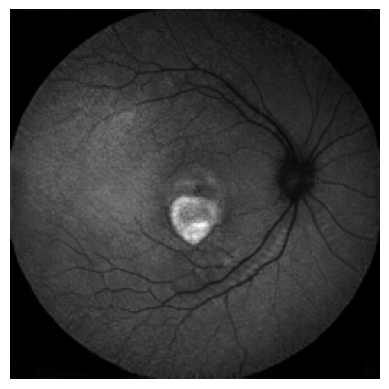

In [89]:
save_folder = "results/gif_imgs_2/"
os.makedirs(save_folder, exist_ok=True)
for i in range(len(interpolations[-1])):
#     plt.figure(figsize=(6, 6))
    plt.axis('off')
    _ = show_tensor_images(interpolations[-1][i], normalize=False, show_image=True, save_path=save_folder+"res_{}".format(i))

### Interpolate between noises

In [25]:
interpolator = Interpolate(gan_model, interp="latents", n_classes=dataset.n_classes, n_interpolation=9, device=device)

In [76]:
label = 'ABCA4'
class_idx = torch.tensor([dataset.class2idx[label]])
latent1 = get_noise(1, z_dim, device)
latent2 = get_noise(1, z_dim, device)
interpolations = interpolator(latent1, latent2, class_idx)
image_adjustor = conditional_msggan.Generator.adjust_dynamic_range
interpolations[-1] = image_adjustor(interpolations[-1])

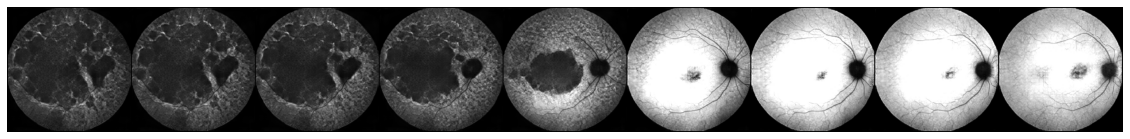

In [77]:
plt.figure(figsize=(20, 6))
_ = plt.axis('off')
_ = show_tensor_images(interpolations[-1], n_rows=9, normalize=False, show_image=True)

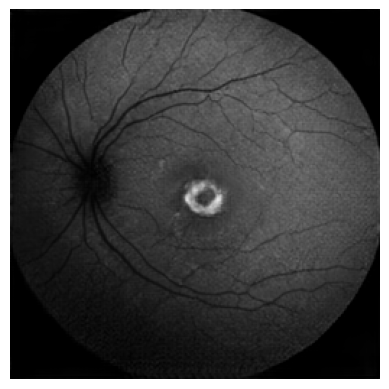

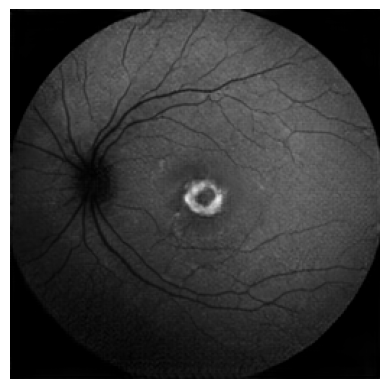

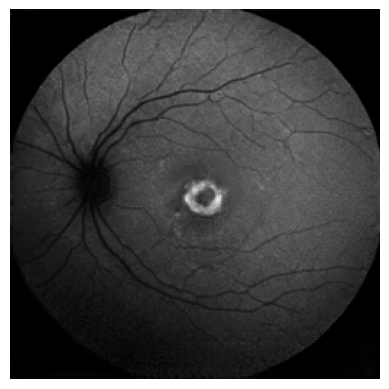

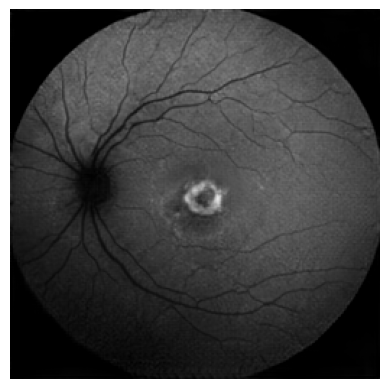

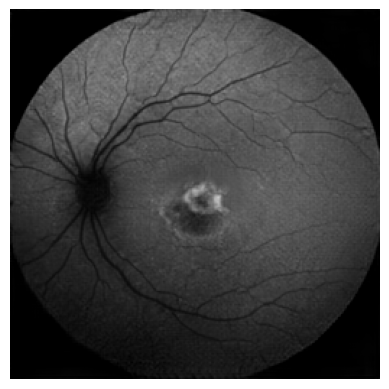

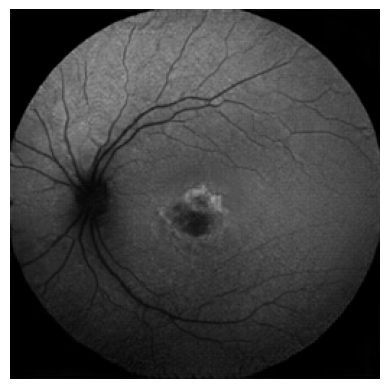

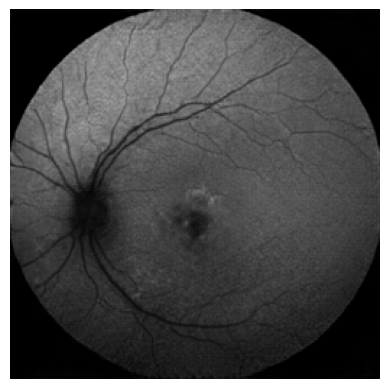

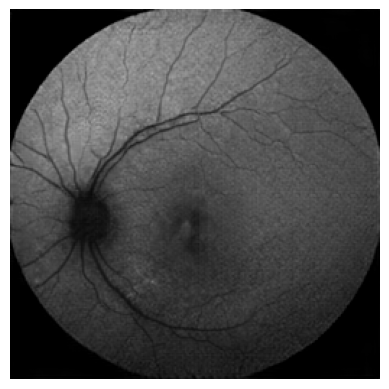

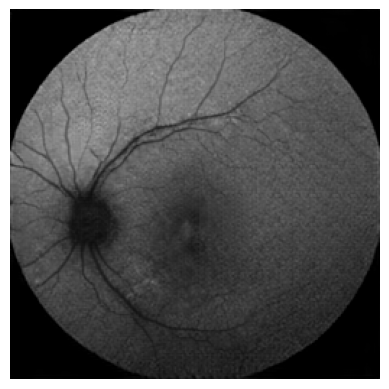

In [31]:
save_folder = "results/gif_imgs_3/"
os.makedirs(save_folder, exist_ok=True)
for i in range(len(interpolations[-1])):
#     plt.figure(figsize=(6, 6))
    plt.axis('off')
    _ = show_tensor_images(interpolations[-1][i], normalize=False, show_image=True, save_path=save_folder+"res_{}".format(i))